In [1]:
import numpy as np
import torch
import pyepo

# random seed
np.random.seed(42)
torch.manual_seed(42)

Auto-Sklearn cannot be imported.


## Data Set and Optimization Solver

In [2]:
# generate data
num_node = 50 # node size
num_data = 1000 # number of training data
num_feat = 10 # size of feature
deg = 4 # polynomial degree
e = 0.5 # noise width
feats, costs = pyepo.data.tsp.genData(num_data+100+1000, num_feat, num_node, deg, e, seed=42)

In [3]:
from model import tspDFJModel
# set solver
optmodel = tspDFJModel(num_node)
# test
optmodel.setObj(costs[0])
sol, obj = optmodel.solve()
print("Obj: {}".format(obj))
tour = optmodel.getTour(sol)
print(" -> ".join(map(str, tour)))

Set parameter Username
Academic license - for non-commercial use only - expires 2024-01-01
Obj: 83.2537
0 -> 5 -> 3 -> 31 -> 42 -> 21 -> 13 -> 7 -> 18 -> 44 -> 36 -> 2 -> 27 -> 11 -> 47 -> 30 -> 10 -> 25 -> 46 -> 19 -> 6 -> 14 -> 39 -> 26 -> 35 -> 33 -> 49 -> 8 -> 22 -> 9 -> 24 -> 15 -> 29 -> 48 -> 17 -> 34 -> 32 -> 4 -> 43 -> 45 -> 23 -> 20 -> 12 -> 41 -> 40 -> 28 -> 38 -> 1 -> 37 -> 16 -> 0


In [4]:
# split data
from sklearn.model_selection import train_test_split
feats, x_test, costs, c_test = train_test_split(feats, costs, test_size=1000, random_state=42)
x_train, x_val, c_train, c_val = train_test_split(feats, costs, test_size=100, random_state=42)

In [5]:
# get training, validation and test dataset
dataset_train_cost = pyepo.data.dataset.optDataset(optmodel, x_train, costs=c_train)
dataset_val = pyepo.data.dataset.optDataset(optmodel, x_val, costs=c_val)
dataset_test = pyepo.data.dataset.optDataset(optmodel, x_test, costs=c_test)

Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:05<00:00, 15.21it/s]


Optimizing for optDataset...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.61it/s]


Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:15<00:00, 13.24it/s]


In [6]:
from dataset import optDatasetConstrs
dataset_train = optDatasetConstrs(optmodel, x_train, costs=c_train) # with binding constr

Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:06<00:00,  4.06it/s]


In [7]:
# get data loader
from torch.utils.data import DataLoader
from dataset import collate_fn
batch_size = 32
loader_train_cost = DataLoader(dataset_train_cost, batch_size=batch_size, shuffle=True)
loader_train = DataLoader(dataset_train, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
loader_val = DataLoader(dataset_val, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)
loader_test = DataLoader(dataset_test, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)

## Prediction Model

In [8]:
import torch
from torch import nn

# build linear model
class LinearRegression(nn.Module):

    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(num_feat, num_node*(num_node-1)//2)

    def forward(self, x):
        out = self.linear(x)
        return out

## Plot 

In [9]:
from matplotlib import pyplot as plt
def plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step):
    # draw loss plot for training
    plt.figure(figsize=(16, 8))
    plt.plot(loss_log, color="c", lw=2)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Iters", fontsize=36)
    plt.ylabel("Loss", fontsize=36)
    plt.title("Loss Curve on Training Set", fontsize=36)
    plt.show()
    # draw regret plot for test
    fig = plt.figure(figsize=(16, 8))
    plt.plot([i * log_step for i in range(len(regret_log_trn))], regret_log_trn,
             color="royalblue", ls="--", alpha=0.7, lw=5, label="Train")
    plt.plot([i * log_step for i in range(len(regret_log_val))], regret_log_val,
             color="lightcoral", ls=":", alpha=0.7, lw=5, label="Val")
    plt.xlim(-1, num_epochs+1)
    plt.ylim(0, 0.8)
    plt.xticks(range(0, num_epochs+1, 5), fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Epoch", fontsize=36)
    plt.ylabel("Regret", fontsize=36)
    plt.legend(fontsize=32)
    plt.title("Regret Curve on Training and Validation Set", fontsize=36)
    plt.show()

## Train

In [10]:
lr = 5e-2
num_epochs = 40
log_step = 2

In [11]:
import time
from tqdm import tqdm
from earlystop import earlyStopper

def pipeline(reg, forward_func, loss_func, lr, num_epochs, log_step, loader_train, loader_val, loader_test, seed=42):
    # set random seed
    np.random.seed(42)
    torch.manual_seed(42)
    # set optimizer
    optimizer = torch.optim.Adam(reg.parameters(), lr=lr)
    # set stopper
    stopper = earlyStopper(patience=3)
    # init log
    loss_log = []
    regret_log_trn = []
    regret_log_val = []
    # running time
    elapsed = 0
    tbar = tqdm(range(num_epochs))
    for epoch in tbar:
        # eval & log
        if epoch % log_step == 0:
            # regret
            regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
            regret_log_trn.append(regret_trn)
            regret_val = pyepo.metric.regret(reg, optmodel, loader_val)
            regret_log_val.append(regret_val)
            tbar.write("Epoch {:3}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".
                       format(epoch, regret_trn*100, regret_val*100))
            # early stop
            if stopper.stop(regret_val):
                print()
                print("Early Stop!")
                break
        # training
        time.sleep(1)
        tick = time.time()
        for data in loader_train:
            # forward pass)
            loss = forward_func(data, reg, loss_func)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_log.append(loss.item())
            tbar.set_description("Epoch {:4.0f}, Loss: {:8.4f}".format(epoch, loss.item()))
        # record time
        tock = time.time()
        elapsed += tock - tick
    # regret
    regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
    regret_log_trn.append(regret_trn)
    regret_val = pyepo.metric.regret(reg, optmodel, loader_val)
    regret_log_val.append(regret_val)
    tbar.write("Epoch {:3}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".
               format(epoch, regret_trn*100, regret_val*100))
    print()
    print("Evaluation:")
    test_regret = pyepo.metric.regret(reg, optmodel, loader_test)
    print("Test Regret: {:.4f}%".format(test_regret*100))
    print("Training Elapsed Time: {:.2f} Sec".format(elapsed))
    return loss_log, regret_log_trn, regret_log_val

### 2-Stage 

In [12]:
# init model
reg = LinearRegression()

In [13]:
from torch import nn
# init loss
mse = nn.MSELoss()

def forward2S(data, reg, loss_func):
    # unzip data
    x, c, w, z = data
    # predict
    cp = reg(x)
    # loss
    loss = loss_func(cp, c)
    return loss

In [14]:
loss_log, regret_log_trn, regret_log_val = pipeline(reg, forward2S, mse, lr, num_epochs, log_step,
                                                    loader_train_cost, loader_val, loader_test)

  0%|                                                                                           | 0/40 [01:20<?, ?it/s]

Epoch   0, Train Regret: 329.3519%, Val Regret: 337.8251%


Epoch    1, Loss:  21.2926:   5%|██▊                                                    | 2/40 [02:33<21:40, 34.22s/it]

Epoch   2, Train Regret:  43.1263%, Val Regret:  44.0535%


Epoch    3, Loss:   8.6119:  10%|█████▌                                                 | 4/40 [03:45<18:55, 31.55s/it]

Epoch   4, Train Regret:  40.6394%, Val Regret:  41.2888%


Epoch    5, Loss:   7.3463:  15%|████████▎                                              | 6/40 [05:00<17:21, 30.63s/it]

Epoch   6, Train Regret:  35.9986%, Val Regret:  37.0549%


Epoch    7, Loss:   7.3743:  20%|███████████                                            | 8/40 [06:11<16:27, 30.85s/it]

Epoch   8, Train Regret:  32.0919%, Val Regret:  33.2628%


Epoch    9, Loss:   8.5302:  25%|█████████████▌                                        | 10/40 [07:26<15:04, 30.16s/it]

Epoch  10, Train Regret:  30.0480%, Val Regret:  31.1751%


Epoch   11, Loss:   6.0899:  30%|████████████████▏                                     | 12/40 [08:43<14:17, 30.63s/it]

Epoch  12, Train Regret:  29.2582%, Val Regret:  30.7279%


Epoch   13, Loss:   5.0777:  35%|██████████████████▉                                   | 14/40 [09:57<13:30, 31.19s/it]

Epoch  14, Train Regret:  28.7887%, Val Regret:  30.0481%


Epoch   15, Loss:   7.9808:  40%|█████████████████████▌                                | 16/40 [11:14<12:24, 31.01s/it]

Epoch  16, Train Regret:  28.6693%, Val Regret:  29.6385%


Epoch   17, Loss:  11.1458:  45%|████████████████████████▎                             | 18/40 [12:24<11:29, 31.32s/it]

Epoch  18, Train Regret:  28.5786%, Val Regret:  29.6612%


Epoch   19, Loss:   7.3882:  50%|███████████████████████████                           | 20/40 [13:37<10:04, 30.24s/it]

Epoch  20, Train Regret:  28.4759%, Val Regret:  29.6640%


Epoch   21, Loss:  11.3801:  55%|█████████████████████████████▋                        | 22/40 [14:52<12:10, 40.59s/it]


Epoch  22, Train Regret:  28.7231%, Val Regret:  29.9719%

Early Stop!
Epoch  22, Train Regret:  28.7231%, Val Regret:  29.9719%

Evaluation:
Test Regret: 29.1480%
Training Elapsed Time: 2.57 Sec


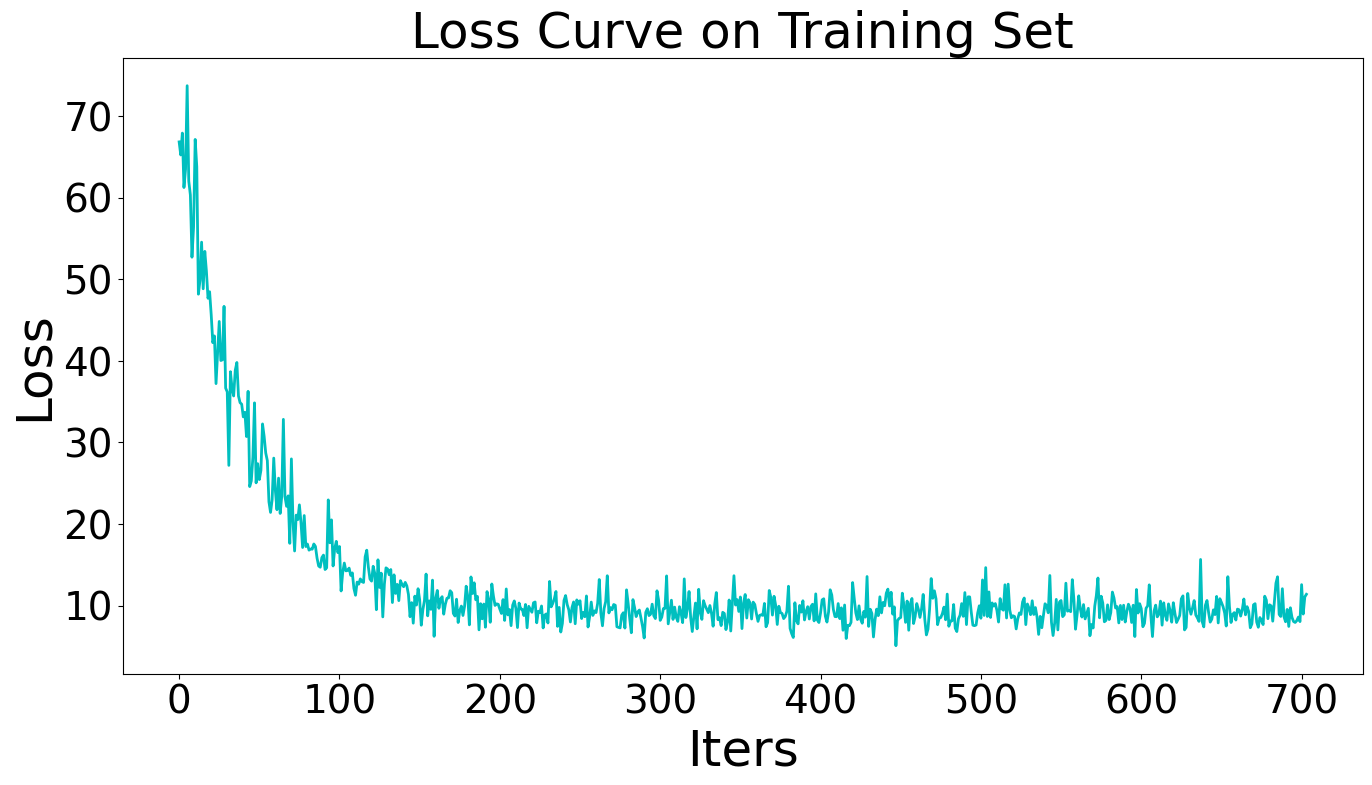

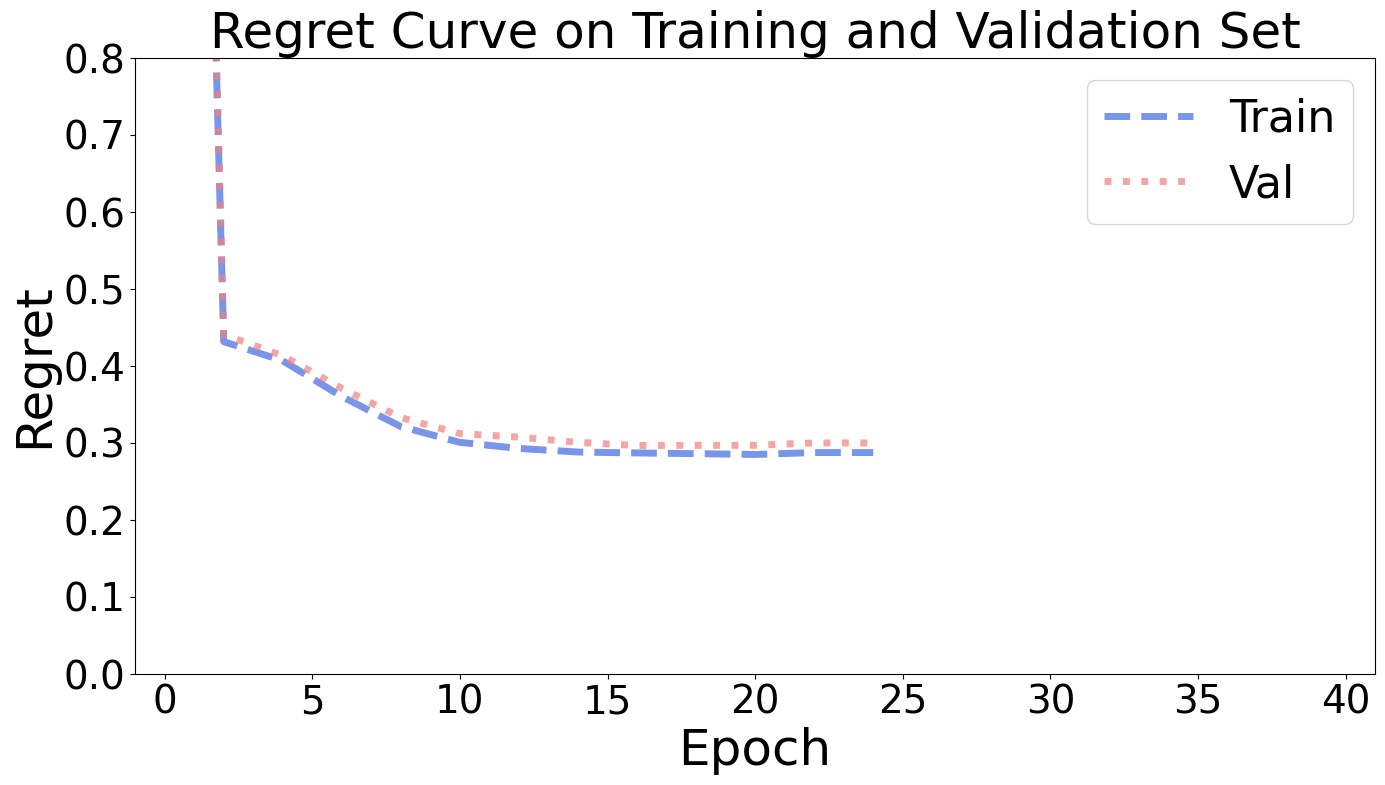

In [15]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Exact Method with Clarabel

In [16]:
# init model
reg = LinearRegression()

In [17]:
from func import exactConeAlignedCosine
# init loss
ca_cos = exactConeAlignedCosine(optmodel, solver="clarabel", processes=8)

def forwardCAVE(data, reg, loss_func):
    # unzip data
    x, _, _, t_ctr = data
    # predict
    cp = reg(x)
    # loss
    loss = loss_func(cp, t_ctr)
    return loss

(CVXPY) Nov 22 03:22:58 AM: Encountered unexpected exception importing solver OSQP:
ImportError('DLL load failed while importing qdldl: The specified module could not be found.')
Num of cores: 8


In [18]:
loss_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                    loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/40 [01:10<?, ?it/s]

Epoch   0, Train Regret: 321.7557%, Val Regret: 333.1257%


Epoch    1, Loss:  -0.9989:   5%|██▊                                                    | 2/40 [03:40<39:38, 62.60s/it]

Epoch   2, Train Regret:  15.4249%, Val Regret:  18.9811%


Epoch    3, Loss:  -0.9996:  10%|█████▌                                                 | 4/40 [06:08<38:58, 64.97s/it]

Epoch   4, Train Regret:  12.5122%, Val Regret:  14.9326%


Epoch    5, Loss:  -0.9998:  15%|████████▎                                              | 6/40 [08:32<36:42, 64.77s/it]

Epoch   6, Train Regret:  11.8802%, Val Regret:  15.0612%


Epoch    7, Loss:  -0.9998:  20%|███████████                                            | 8/40 [10:49<34:25, 64.54s/it]

Epoch   8, Train Regret:  10.8986%, Val Regret:  15.3481%


Epoch    9, Loss:  -0.9998:  25%|█████████████▌                                        | 10/40 [13:03<39:11, 78.38s/it]


Epoch  10, Train Regret:  10.5056%, Val Regret:  15.6741%

Early Stop!
Epoch  10, Train Regret:  10.4978%, Val Regret:  15.6741%

Evaluation:
Test Regret: 15.5909%
Training Elapsed Time: 309.51 Sec


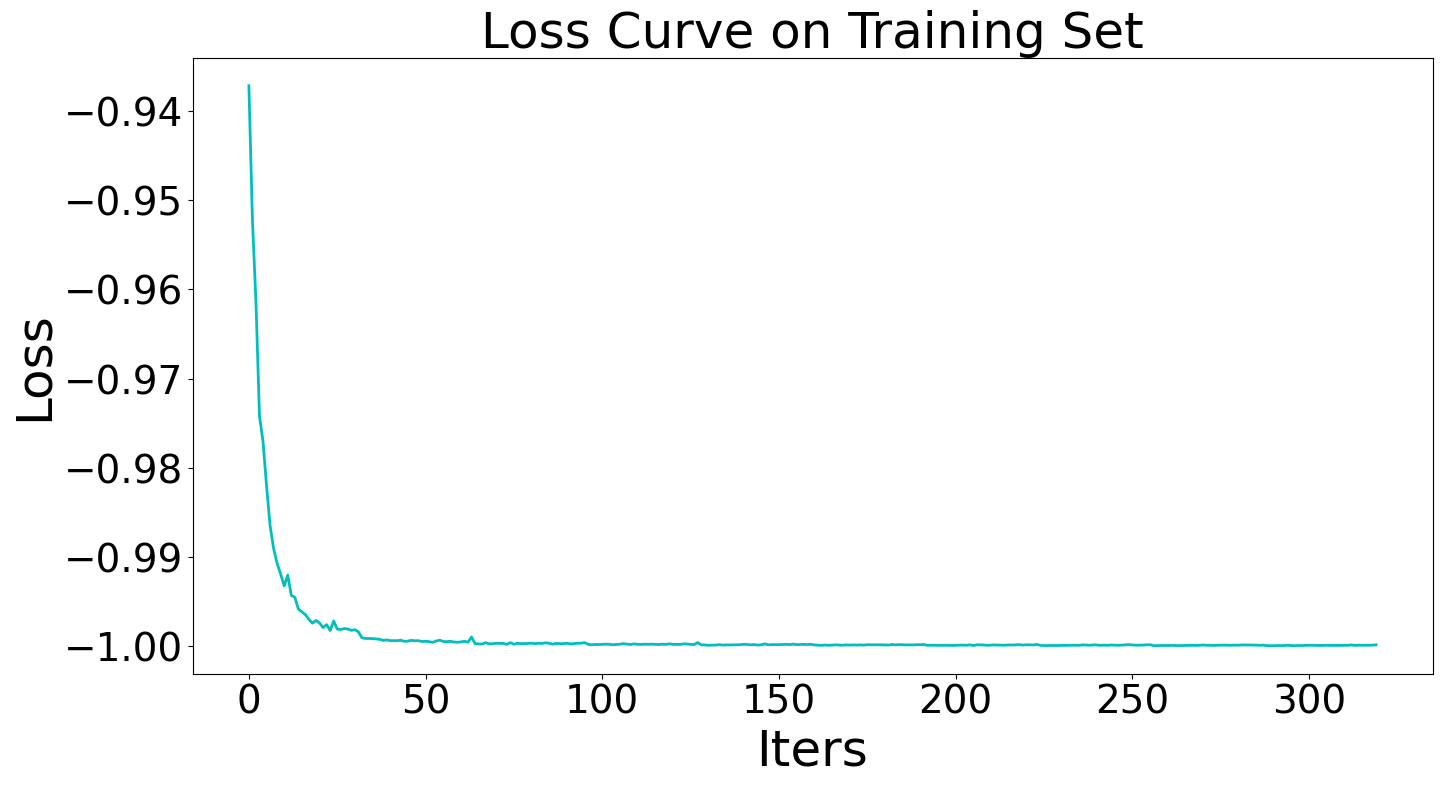

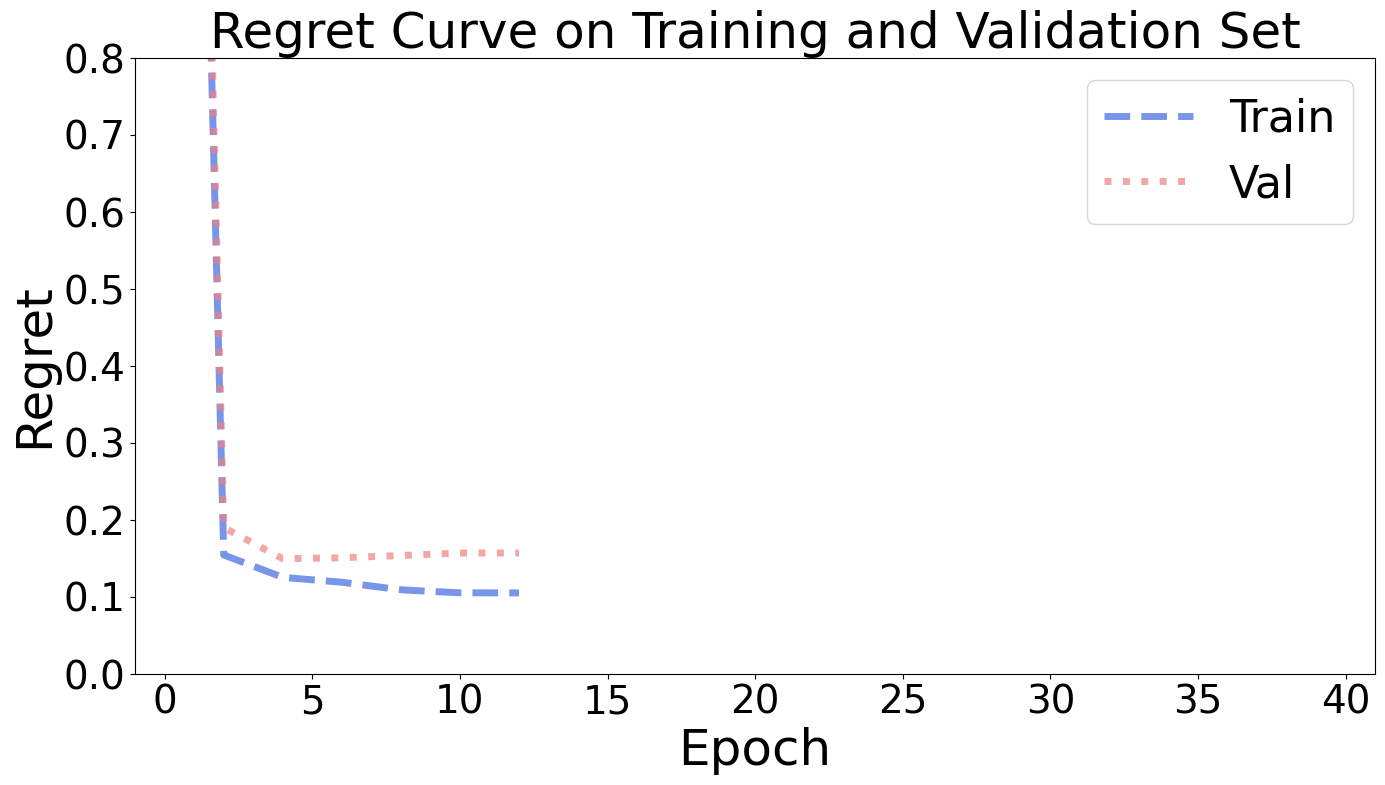

In [19]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### PFYL

In [20]:
# init model
reg = LinearRegression()

In [21]:
from pyepo.func import perturbedFenchelYoung
# init pfyl loss
pfy = perturbedFenchelYoung(optmodel, n_samples=1, sigma=1.0, processes=8)

def forwardPFY(data, reg, loss_func):
    # unzip data
    x, _, w, _ = data
    # predict
    cp = reg(x)
    # loss
    loss = loss_func(cp, w)
    return loss

Num of cores: 8


In [22]:
loss_log, regret_log_trn, regret_log_val = pipeline(reg, forwardPFY, pfy, lr, num_epochs, log_step,
                                                    loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/40 [01:10<?, ?it/s]

Epoch   0, Train Regret: 326.3308%, Val Regret: 328.6709%


Epoch    1, Loss:  51.0000:   5%|██▊                                                    | 2/40 [03:17<34:32, 54.55s/it]

Epoch   2, Train Regret:   8.7734%, Val Regret:   9.5034%


Epoch    3, Loss:  44.2500:  10%|█████▌                                                 | 4/40 [05:25<34:02, 56.73s/it]

Epoch   4, Train Regret:   7.6856%, Val Regret:   8.5984%


Epoch    5, Loss:  44.2500:  15%|████████▎                                              | 6/40 [07:32<32:37, 57.57s/it]

Epoch   6, Train Regret:   7.2597%, Val Regret:   8.6135%


Epoch    7, Loss:  41.7500:  20%|███████████                                            | 8/40 [09:43<30:42, 57.57s/it]

Epoch   8, Train Regret:   7.0212%, Val Regret:   7.8316%


Epoch    9, Loss:  39.2500:  25%|█████████████▌                                        | 10/40 [12:00<29:01, 58.05s/it]

Epoch  10, Train Regret:   6.9114%, Val Regret:   8.0739%


Epoch   11, Loss:  40.0000:  30%|████████████████▏                                     | 12/40 [14:16<27:39, 59.28s/it]

Epoch  12, Train Regret:   6.7405%, Val Regret:   8.1026%


Epoch   13, Loss:  38.7500:  35%|██████████████████▉                                   | 14/40 [16:32<30:44, 70.93s/it]


Epoch  14, Train Regret:   6.7241%, Val Regret:   8.1387%

Early Stop!
Epoch  14, Train Regret:   6.7286%, Val Regret:   8.1387%

Evaluation:
Test Regret: 8.1595%
Training Elapsed Time: 357.48 Sec


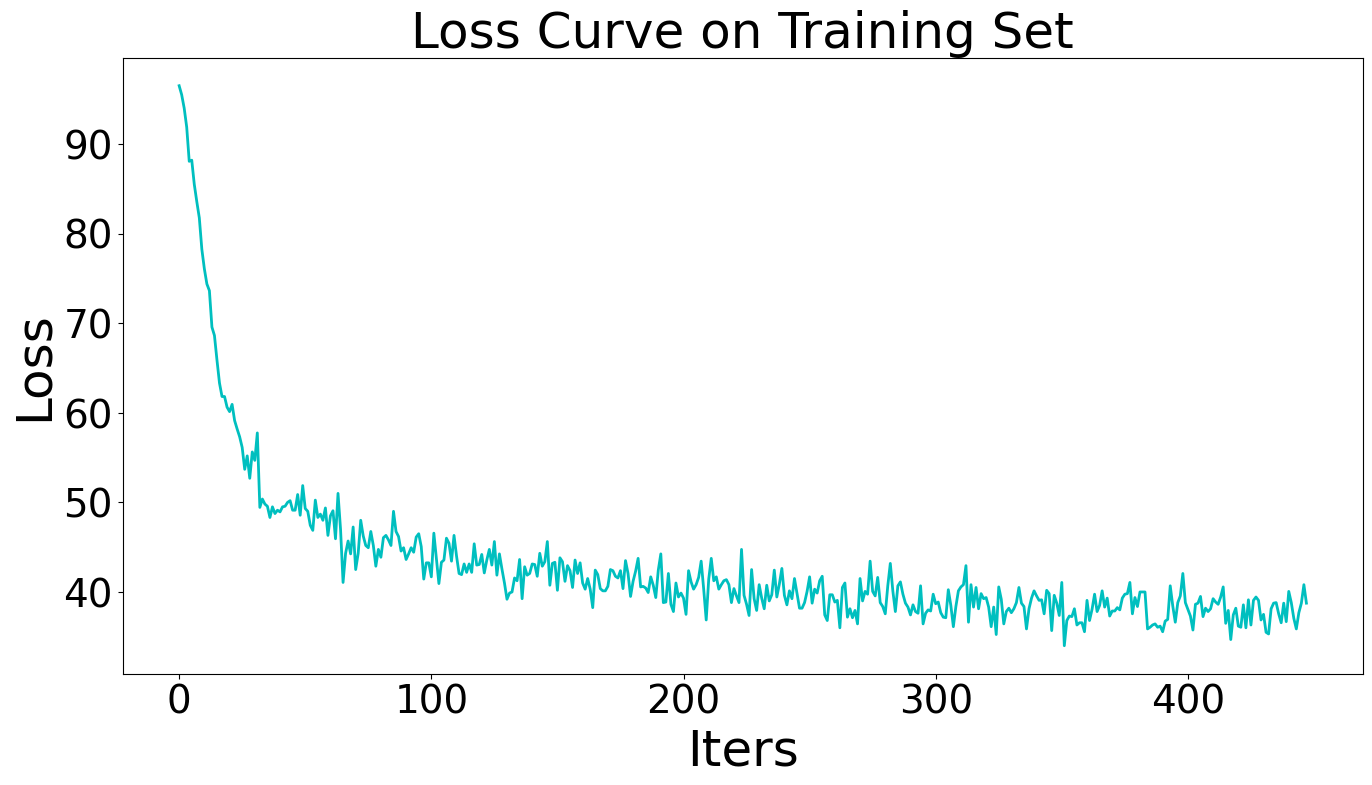

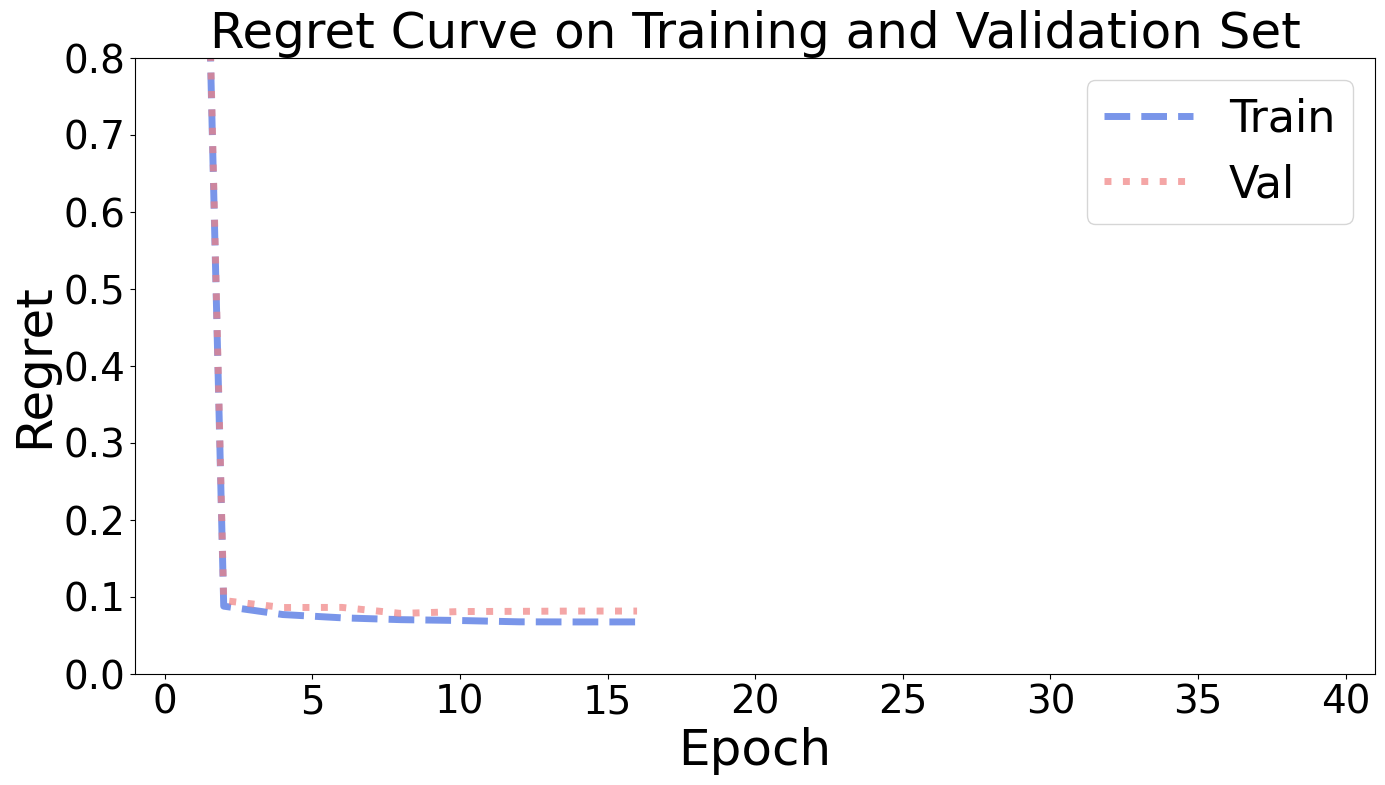

In [23]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### NCE 

In [24]:
# init model
reg = LinearRegression()

In [25]:
from pyepo.func import NCE
# init nce loss
nce = NCE(optmodel, processes=8, solve_ratio=0.05, dataset=dataset_train_cost)

def forwardNCE(data, reg, loss_func):
    # unzip data
    x, _, w, _ = data
    # predict
    cp = reg(x)
    # loss
    loss = loss_func(cp, w)
    return loss

Num of cores: 8


In [26]:
loss_log, regret_log_trn, regret_log_val = pipeline(reg, forwardNCE, nce, lr, num_epochs, log_step,
                                                    loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/40 [01:12<?, ?it/s]

Epoch   0, Train Regret: 318.5132%, Val Regret: 329.2496%


Epoch    1, Loss: -331.8181:   5%|██▋                                                   | 2/40 [02:48<25:13, 39.83s/it]

Epoch   2, Train Regret:  16.3698%, Val Regret:  18.5397%


Epoch    3, Loss: -616.1322:  10%|█████▍                                                | 4/40 [04:25<25:33, 42.61s/it]

Epoch   4, Train Regret:  15.0063%, Val Regret:  16.5869%


Epoch    5, Loss: -984.7499:  15%|████████                                              | 6/40 [06:05<23:54, 42.20s/it]

Epoch   6, Train Regret:  14.2042%, Val Regret:  16.2535%


Epoch    7, Loss: -1276.1884:  20%|██████████▌                                          | 8/40 [07:49<22:17, 41.81s/it]

Epoch   8, Train Regret:  13.9207%, Val Regret:  15.5376%


Epoch    9, Loss: -1616.4819:  25%|█████████████                                       | 10/40 [09:33<21:52, 43.75s/it]

Epoch  10, Train Regret:  13.5271%, Val Regret:  15.7727%


Epoch   11, Loss: -1881.0509:  30%|███████████████▌                                    | 12/40 [11:17<20:33, 44.06s/it]

Epoch  12, Train Regret:  13.3945%, Val Regret:  15.4322%


Epoch   13, Loss: -2208.2446:  35%|██████████████████▏                                 | 14/40 [12:53<18:55, 43.67s/it]

Epoch  14, Train Regret:  13.2677%, Val Regret:  15.3682%


Epoch   15, Loss: -2719.3787:  40%|████████████████████▊                               | 16/40 [14:30<17:29, 43.74s/it]

Epoch  16, Train Regret:  13.0854%, Val Regret:  15.3361%


Epoch   17, Loss: -3291.6147:  45%|███████████████████████▍                            | 18/40 [16:08<15:26, 42.10s/it]

Epoch  18, Train Regret:  12.8864%, Val Regret:  15.2547%


Epoch   19, Loss: -3646.2034:  50%|██████████████████████████                          | 20/40 [17:50<13:58, 41.91s/it]

Epoch  20, Train Regret:  12.7152%, Val Regret:  14.9568%


Epoch   21, Loss: -3866.0225:  55%|████████████████████████████▌                       | 22/40 [19:30<12:42, 42.33s/it]

Epoch  22, Train Regret:  12.7040%, Val Regret:  14.8018%


Epoch   23, Loss: -4232.2974:  60%|███████████████████████████████▏                    | 24/40 [21:10<11:25, 42.82s/it]

Epoch  24, Train Regret:  12.5510%, Val Regret:  14.9024%


Epoch   25, Loss: -4284.9146:  65%|█████████████████████████████████▊                  | 26/40 [22:43<09:56, 42.59s/it]

Epoch  26, Train Regret:  12.5416%, Val Regret:  15.0127%


Epoch   27, Loss: -4101.9980:  70%|████████████████████████████████████▍               | 28/40 [24:26<10:28, 52.36s/it]


Epoch  28, Train Regret:  12.5359%, Val Regret:  15.1469%

Early Stop!
Epoch  28, Train Regret:  12.5325%, Val Regret:  15.1469%

Evaluation:
Test Regret: 14.5671%
Training Elapsed Time: 261.98 Sec


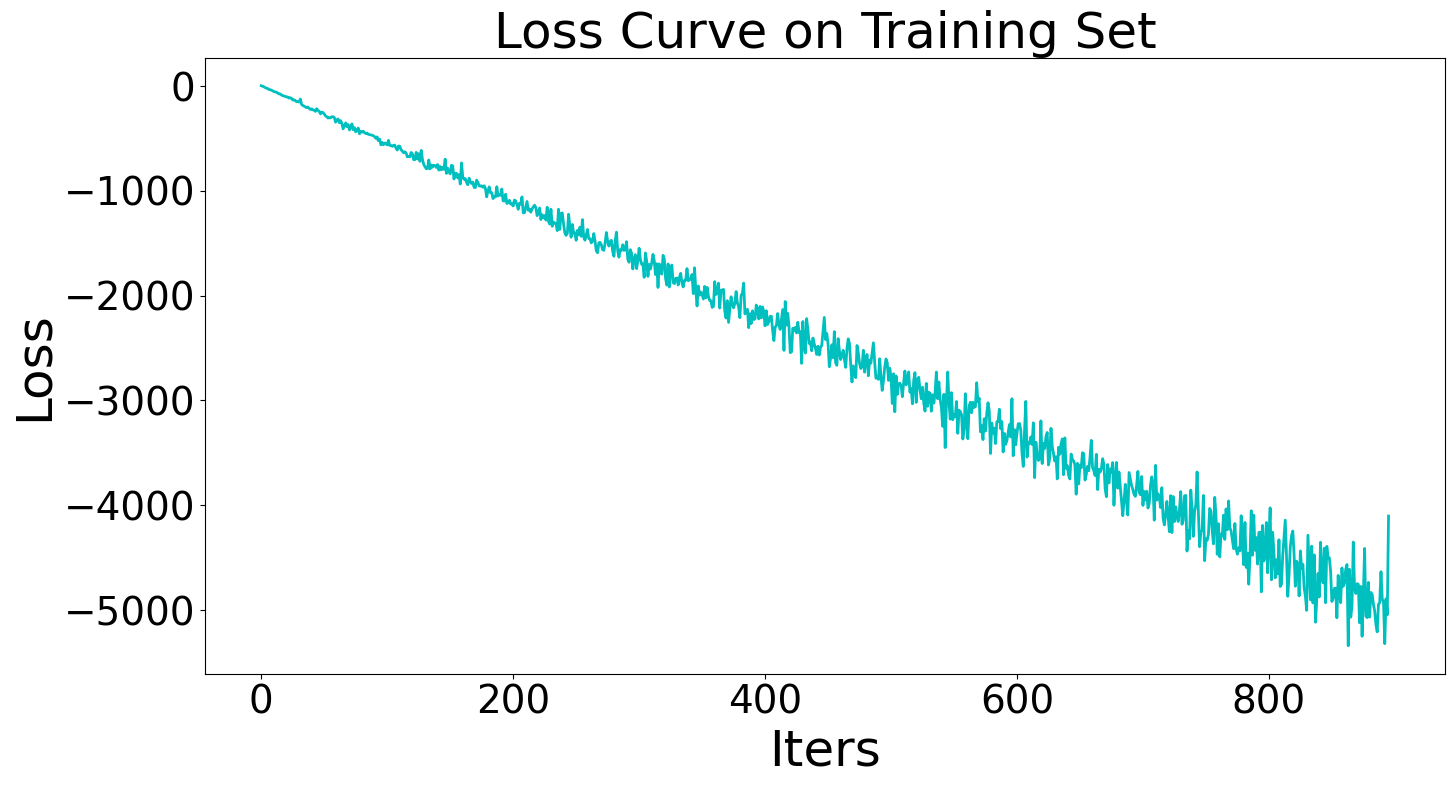

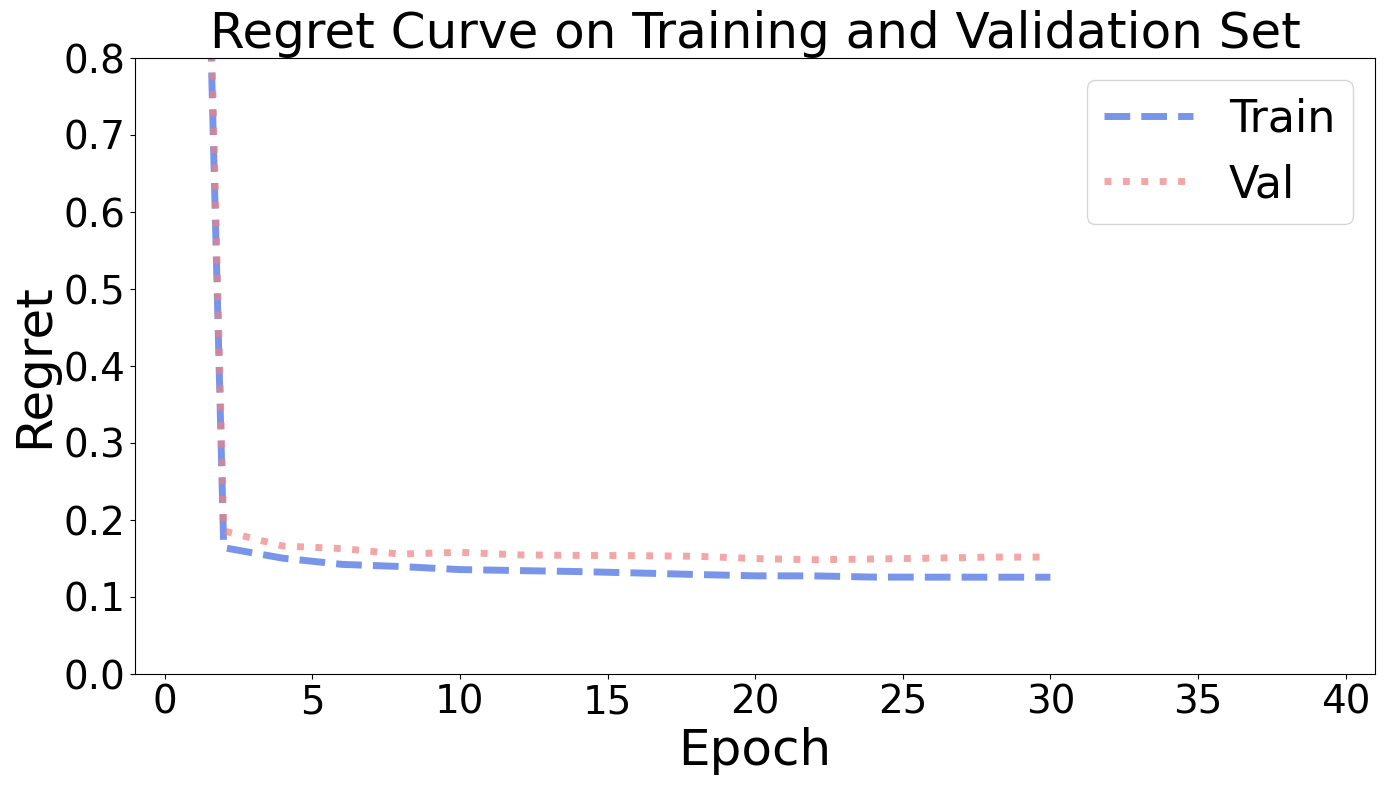

In [27]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)